In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ====== INPUT PARAMETERS ======
# Ring geometry (in mm)
# outer_diameter
# inner_diameter
# height
# Residual induction (Tesla)
# ====== CONSTANTS ======
mu0 = 4 * np.pi * 1e-7  # H/m (magnetic constant)
h = 6.62607015e-34 #SI unit
g = 2.002319
uB = 9.2740100657e-24

y0 = -2.132761e-6        #typical values from ODMR experiment
sigma = 6.376516e5
hf = 2.207467e6
D = 2.878042e+09
a = 1e-5

class Bar_magnet:
    '''
    SI units
    '''
    Length: float
    Width: float
    Thickness: float
    Distance : float
    Mx : float
    My : float
    Mz : float
    def __init__(self, Length, Width, Distance, Thickness, My, Mx = 0, Mz = 0):
        self.Length = Length
        self.Width = Width
        self.Thickness = Thickness
        self.Distance = Distance
        self.Mx = Mx
        self.My = My
        self.Mz = Mz
class Ring_magnet:
    R_in : float
    R_out: float
    H : float
    Mx : float
    My : float
    Mz : float
    def __init__(self, R_in, R_out, H, Mz, Mx = 0, My = 0):
        self.R_in = R_in
        self.R_out = R_out
        self.H = H
        self.Mx = Mx
        self.My = My
        self.Mz = Mz

def mm2m(x):
    """
    Helper function: convert mm to meters
    """
    return x * 1e-3

def dipole(r_vec:np.array, m_vec:np.array):
  """
  Input: r_vec: seperation vector
         m_vec: magnetic dipole of one segment
  Output: Magnetic field generated by the dipole at the observation point
  """
  # Magnetic dipole field formula:
  # B = μ0/(4π) * [3(m·r̂)r̂ - m] / r^3
  r_mag = np.linalg.norm(r_vec)
  if r_mag < 1e-9:
    return np.array([0,0,0])  # Skip self-contribution
  else:
    r_hat = r_vec / r_mag
    m_dot_rhat = np.dot(m_vec, r_hat)
    B_vec = (mu0 / (4*np.pi)) * (3 * m_dot_rhat * r_hat - m_vec) / (r_mag**3)
    return B_vec

# ====== FUNCTION TO COMPUTE FIELD AT A POINT ======
def field_ring_axial(magnet:Ring_magnet, r_obs, z_obs, n_r=40, n_phi=120, n_z=10, fi = 0):
    """
    Compute the magnetic field from an axially magnetized ring at a given point.

    Parameters:
        r_obs, z_obs, fi : observation point coordinates in meters and radians
        n_r, n_phi, n_z : discretization steps in r, phi, z for numerical integration
        Dimension of the ring magnet:
          Mz, Mx, My : magnetization in z, x, y directions (H/m)
          R_in, R_out : inner and outer radius of the ring magnet (m)
          H : thickness of the ring magnet (m)
    Returns:
        (B_x, B_y, Bz) : x, y, z components of B (Tesla)
    """
    R_in = magnet.R_in
    R_out = magnet.R_out
    H = magnet.H
    Mx = magnet.Mx
    My = magnet.My
    Mz = magnet.Mz

    # Discretize the ring volume
    r_vals = np.linspace(R_in, R_out, n_r)
    phi_vals = np.linspace(0, 2*np.pi, n_phi, endpoint=False)
    z_vals = np.linspace(-H/2, H/2, n_z)

    # Volume element sizes
    dr = (R_out - R_in) / (n_r - 1)
    dphi = 2*np.pi / n_phi
    dz = H / (n_z - 1)

    Bz_total = 0.0
    Bx_total = 0.0
    By_total = 0.0
    for r in r_vals:
        for phi in phi_vals:
            for z in z_vals:
                # Source element coordinates
                x_src = r * np.cos(phi)
                y_src = r * np.sin(phi)
                z_src = z

                # Vector from source to observation point
                dx = r_obs * np.cos(fi) - x_src
                dy = r_obs * np.sin(fi) - y_src
                dzv = z_obs - z_src

                r_vec = np.array([dx, dy, dzv])
                # r_mag = np.linalg.norm(r_vec)

                # if r_mag < 1e-9:
                #     continue  # Skip self-contribution

                # Volume of the element
                dV = r * dr * dphi * dz

                # Magnetic moment of the element (aligned along z-axis)
                m_vec = np.array([Mx * dV, My * dV, Mz * dV])

                # Magnetic dipole field formula:
                # B = μ0/(4π) * [3(m·r̂)r̂ - m] / r^3
                # r_hat = r_vec / r_mag
                # m_dot_rhat = np.dot(m_vec, r_hat)
                # B_vec = (mu0 / (4*np.pi)) * (3 * m_dot_rhat * r_hat - m_vec) / (r_mag**3)
                B_vec = dipole(r_vec, m_vec)
                # Add axial (z) component
                Bz_total += B_vec[2]

                # Radial component = projection along x-axis at φ=0
                Bx_total += B_vec[0]
                By_total += B_vec[1]
    return Bx_total, By_total, Bz_total

def field_bar(magnet:Bar_magnet, x_obs, y_obs, z_obs, n_x=60, n_y=20, n_z=40):
    """
    Compute the magnetic field from an axially magnetized ring at a given point.

    Parameters:
        x_obs, y_obs, z_obs : observation point coordinates (m)
        n_x, n_y, n_z : discretization steps in x, y, z for numerical integration
        Dimension of the bar magnet:
          Mz, Mx, My : magnetization in z, x, y directions (H/m)
          Length, Width, Thickness of the bar magnet (m)
    Returns:
        (B_x, B_y, Bz) : x, y, z components of B (Tesla)
    """
    Length = magnet.Length
    Width = magnet.Width
    Thickness = magnet.Thickness
    Distance = magnet.Distance
    Mx = magnet.Mx
    My = magnet.My
    Mz = magnet.Mz
    x_vals = np.linspace(-Length/2, Length/2, n_x)
    y_vals = np.concat((np.linspace(-Distance/2 - Thickness, -Distance/2, n_y), np.linspace(Distance/2, Distance/2 + Thickness, n_y)))
    z_vals = np.linspace(-Width/2, Width/2, n_z)
    # Volume element sizes
    Dx = Length / (n_x - 1)
    Dy = Thickness / (n_y - 1)
    Dz = Width / (n_z - 1)
    Bz_total = 0.0
    Bx_total = 0.0
    By_total = 0.0
    dV = Dx * Dy * Dz
    for x in x_vals:
        for y in y_vals:
            for z in z_vals:
                dx = x_obs - x
                dy = y_obs - y
                dz = z_obs - z
                r_vec = np.array([dx, dy, dz])
                m_vec = np.array([Mx * dV, My * dV, Mz * dV])
                B_vec = dipole(r_vec, m_vec)
                Bx_total += B_vec[0]
                By_total += B_vec[1]
                Bz_total += B_vec[2]
    return Bx_total, By_total, Bz_total

# ====== Table display ======

def table_display(magnet:Ring_magnet, radial_offset, z_values):
  """
  Table display of magnetic field distribution at different height z
  radial_offset: radial offset from the axis for comparison (mm)
  z_values: array of axial distances from the bottom of magnet (mm)
  """
  print(f"{'z (mm)':>7} | {'Bx_axis (mT)':>12} | {f'B_x={radial_offset}mm (mT)':>14} | {'By_axis (mT)':>12}  |{f'B_y={radial_offset}mm (mT)':>14} |  {'Bz_axis (mT)':>12} |{f'B_z={radial_offset}mm (mT)':>14} |  {'|ΔB_x| (µT)':>10}  |  {'|ΔB_y| (µT)':>10}  |  {'|ΔB_z| (µT)':>10}  |  {'|ΔB| (µT)':>10}")
  for z_mm in z_values:
      # Field on the axis
      Bx_axis, By_axis, Bz_axis = field_ring_axial(magnet, 0.0, mm2m(z_mm))
      # Field at radial offset
      Bx_off, By_off, Bz_off = field_ring_axial(mm2m(radial_offset), mm2m(z_mm))
      # Convert to mT for printing
      Bz_axis_mT = Bz_axis * 1e3
      Bz_off_mT = Bz_off * 1e3
      Bx_axis_mT = Bx_axis * 1e3
      Bx_off_mT = Bx_off * 1e3
      By_axis_mT = By_axis * 1e3
      By_off_mT = By_off * 1e3
      # Absolute difference in µT
      deltaz_uT = abs(Bz_axis_mT - Bz_off_mT) * 1e3
      deltax_uT = abs(Bx_axis_mT - Bx_off_mT) * 1e3
      deltay_uT = abs(By_axis_mT - By_off_mT) * 1e3
      delta_uT = np.sqrt(deltax_uT**2 + deltay_uT**2 + deltaz_uT**2)
      # Relative difference in ppm
      #delta_ppm = delta_uT / (B_axis_mT * 1e3) * 1e6

      print(f"{z_mm:7.1f} | {Bx_axis_mT:12.4f} | {Bx_off_mT:14.4f} |  {By_axis_mT:12.4f} | {By_off_mT:14.4f}| {Bz_axis_mT:12.4f}  | {Bz_off_mT:14.4f}| {deltax_uT:10.2f}    |{deltay_uT:10.2f}     |{deltaz_uT:10.2f}     |{delta_uT:10.2f} ")


def vector_transf(Bx, By, Bz, yangle, xangle):
  """
  Transform B vector from the frame of ring magnet to that of sample plate
  """
  yangle = -yangle
  xangle = -xangle
  B = np.array([Bx, By, Bz])
  rot_matrix_y = np.array([[np.cos(yangle), 0, -np.sin(yangle)],
                [0, 1, 0],
                [np.sin(yangle), 0, np.cos(yangle)]])
  rot_matrix_x = np.array([[1, 0, 0],
                [0, np.cos(xangle), -np.sin(xangle)],
                [0, np.sin(xangle), np.cos(xangle)]])
  rot = np.matmul(rot_matrix_x, rot_matrix_y)
  B_new = np.matmul(rot, B)
  return B_new[0], B_new[1], B_new[2]

def azimuthal_angle(x,y):
  """
  Compute azimuthal angle
  Input: x, y
  Output: fi in radians
  """
  if x > 0 and y >= 0:
    fi = np.arctan(y/x)
  elif x == 0 and y > 0:
    fi = np.pi/2
  elif x == 0 and y < 0:
    fi = -np.pi/2
  elif x < 0 and y >= 0:
    fi = np.arctan(y/x) + np.pi
  elif x < 0 and y < 0:
    fi = np.arctan(y/x) + np.pi
  elif x > 0 and y < 0:
    fi = np.arctan(y/x)
  else:
    fi = 0
  return fi

def rotation(x, y, z, yangle, xangle):
  """
  rotate matrix point by yangle and xangle
  Input: position x, y, z and angles yangle, xangle
  Output: position in cylindrical coordinate system (r, z, fi) ## fi in radians
  """
  position = np.array([x,y,0])
  rotation_y = np.array([[np.cos(yangle), 0, -np.sin(yangle)],
                [0, 1, 0],
                [np.sin(yangle), 0, np.cos(yangle)]])

  rotation_x = np.array([[1, 0, 0],
                [0, np.cos(xangle), -np.sin(xangle)],
                [0, np.sin(xangle), np.cos(xangle)]])
  rotation = np.matmul(rotation_x , rotation_y)
  position_new = np.matmul(rotation, position)
  position_new[2] += z
  r = np.sqrt(position_new[0]**2 + position_new[1]**2)
  x_new, y_new = position_new[0], position_new[1]
  fi = azimuthal_angle(x_new, y_new)
  return r, position_new[2], fi

def rotation_cartesian(x, y, z, yangle, xangle):
  """
  rotate matrix point by yangle and xangle
  Input: position x, y, z and angles yangle, xangle
  Output: position in cylindrical coordinate system (r, z, fi) ## fi in radians
  """
  position = np.array([x,y,0])
  rotation_y = np.array([[np.cos(yangle), 0, -np.sin(yangle)],
                [0, 1, 0],
                [np.sin(yangle), 0, np.cos(yangle)]])

  rotation_x = np.array([[1, 0, 0],
                [0, np.cos(xangle), -np.sin(xangle)],
                [0, np.sin(xangle), np.cos(xangle)]])
  rotation = np.matmul(rotation_x , rotation_y)
  position_new = np.matmul(rotation, position)
  position_new[2] += z
  return position_new

def magnetic_profile(magnet:Ring_magnet, z_mm, yangle = 0, xangle = 0):
  """
  Magnetic field profile, or magnetic field at each matrix point, at a given z-coordinate.
  Parameters: Dimensions and magnetization of the magnet R_in, R_out, H, Mx, My, Mz
  z_mm is the height of the center of the sample, yangle is the rotation angle of the sample around y axis, and xangle is the rotation angle of the sample around x axis
  The sample is assumed to be parallel to y axis and angle 0 by default.
  Output: three matrices (matrix_B_x, matrix_B_y, matrix_B_z), where the first index corresponds to x index and the second to the y index. Magnetic field are in the rotated frame.
  """
  matrix_B_x = np.zeros((5,5),float)
  matrix_B_y = np.zeros((5,5),float)
  matrix_B_z = np.zeros((5,5),float)
  position_el = np.linspace(-0.8,0.8,5)  #mm

  for i in range(5):
    for j in range(5):
      r, z, fi = rotation(position_el[i], position_el[j], z_mm, yangle = yangle, xangle = xangle)
      Bx_axis, By_axis, Bz_axis = field_ring_axial(magnet, mm2m(r), mm2m(z), fi = fi)
      matrix_B_x[i][j], matrix_B_y[i][j], matrix_B_z[i][j] = vector_transf(Bx_axis, By_axis, Bz_axis, yangle, xangle)

  return matrix_B_x, matrix_B_y, matrix_B_z


def magnetic_profile(magnet:Bar_magnet, z_mm, yangle = 0, xangle = 0):
  """
  Magnetic field profile, or magnetic field at each matrix point, at a given z-coordinate.
  Parameters: Dimensions and magnetization of the magnet R_in, R_out, H, Mx, My, Mz
  z_mm is the height of the center of the sample, yangle is the rotation angle of the sample around y axis, and xangle is the rotation angle of the sample around x axis
  The sample is assumed to be parallel to y axis and angle 0 by default.
  Output: three matrices (matrix_B_x, matrix_B_y, matrix_B_z), where the first index corresponds to x index and the second to the y index. Magnetic field are in the rotated frame.
  """

  matrix_B_x = np.zeros((5,5),float)
  matrix_B_y = np.zeros((5,5),float)
  matrix_B_z = np.zeros((5,5),float)
  position_el = np.linspace(-0.8,0.8,5)  #mm

  for i in range(5):
    for j in range(5):
      x, y, z = rotation_cartesian(position_el[i], position_el[j], z_mm, yangle = yangle, xangle = xangle)
      Bx_axis, By_axis, Bz_axis = field_bar(magnet, mm2m(x), mm2m(y), mm2m(z))
      matrix_B_x[i][j], matrix_B_y[i][j], matrix_B_z[i][j] = vector_transf(Bx_axis, By_axis, Bz_axis, yangle, xangle)

  return matrix_B_x, matrix_B_y, matrix_B_z


def magnetic_profile_point(magnet:Ring_magnet, x_mm, y_mm, z_mm, yangle = 0, xangle = 0):
  """
  Magnetic field profile of a signgle point, at a given z-coordinate.
  parameters: z_mm is the height of the center of the sample, yangle is the rotation angle of the sample around y axis, and xangle is the rotation angle of the sample around x axis
  The sample is assumed to be parallel to y axis and angle 0 by default.
  """
  r, z, fi = rotation(x_mm, y_mm, z_mm, yangle = yangle, xangle = xangle)
  Bx_0, By_0, Bz_0 = field_ring_axial(magnet, mm2m(r), mm2m(z), fi = fi)
  B_x, B_y, B_z = vector_transf(Bx_0, By_0, Bz_0, yangle, xangle)

  return B_x, B_y, B_z

def magnetic_profile_point(magnet:Bar_magnet, x_mm, y_mm, z_mm, yangle = 0, xangle = 0):
  """
  Magnetic field profile of a signgle point, at a given z-coordinate.
  parameters: z_mm is the height of the center of the sample, yangle is the rotation angle of the sample around y axis, and xangle is the rotation angle of the sample around x axis
  The sample is assumed to be parallel to y axis and angle 0 by default.
  """
  x, y, z = rotation_cartesian(x_mm, y_mm, z_mm, yangle = yangle, xangle = xangle)
  Bx_0, By_0, Bz_0 = field_bar(magnet, mm2m(x), mm2m(y), mm2m(z))
  B_x, B_y, B_z = vector_transf(Bx_0, By_0, Bz_0, yangle, xangle)
  return B_x, B_y, B_z



def gauss_33(x,x0,a):
  y = y0 - a*np.exp(-(x-x0)**2/(2*sigma**2))-a*np.exp(-(x-x0-hf)**2/(2*sigma**2))-a*np.exp(-(x-x0+hf)**2/(2*sigma**2))
  return y
def y(x,peaks:np.array):         # simulated spectrum
  y = 0
  for i in range(peaks.shape[1]):
    y += gauss_33(x,peaks[0,i],peaks[1,i])
  return y
def ODMR_sim(Bx,By,Bz):
  num_peaks = 8
  peaks = np.zeros((2,num_peaks))
  df = np.zeros(4)
  B = np.sqrt(Bx**2 + By**2+ Bz**2)
  theta = np.arccos(Bz/B)
  B_rho = np.sqrt(Bx**2 + By**2)
  phi = azimuthal_angle(Bx, By)
  df[0] = abs((1/h)*2*g*uB* (B * np.sin(theta) * (np.cos(phi) + np.sin(phi)) + B * np.cos(theta)))
  df[1] = abs((1/h)*2*g*uB* (B * np.sin(theta) * (np.cos(phi) - np.sin(phi)) - B * np.cos(theta)))
  df[2] = abs((1/h)*2*g*uB* (B * np.sin(theta) * (np.sin(phi) - np.cos(phi)) - B * np.cos(theta)))
  df[3] = abs((1/h)*2*g*uB* (-B * np.sin(theta) * (np.cos(phi) + np.sin(phi)) + B * np.cos(theta)))
  for i in range(4):
    peaks[0][i] = D - df[i]/2
    peaks[0][num_peaks-1-i] = D + df[i]/2
    peaks[1][i] = a
    peaks[1][num_peaks-1-i] = a
  return peaks


In [ ]:
Br = 1.32     # Residual induction of NdFeB magnets
mu0 = 4 * np.pi * 1e-7  # H/m (magnetic constant)
My = Br / mu0

length = 25.4 * 3
width = 3.17
thickness = 12.7 # can be varied
distance = 30

Length = mm2m(length)
Width = mm2m(width)
Thickness = mm2m(thickness)
Distance = mm2m(distance)
bar_magnet = Bar_magnet(Length, Width, Distance, Thickness, My)

#table_display(Mz, radial_offset, z_values, R_in, R_out, H)
z_mm = width/2 + 1          #height of the sample
yangle = 0 * np.pi/180          #pitch angle of the sample
xangle = 0 * np.pi/180
matrix_B_x, matrix_B_y, matrix_B_z = magnetic_profile(bar_magnet, z_mm, yangle = yangle, xangle = xangle)


Magnet 1

length = 76.20 mm
width = 3.17 mm
thickness = 12.7 mm
distance = 30.0 mm


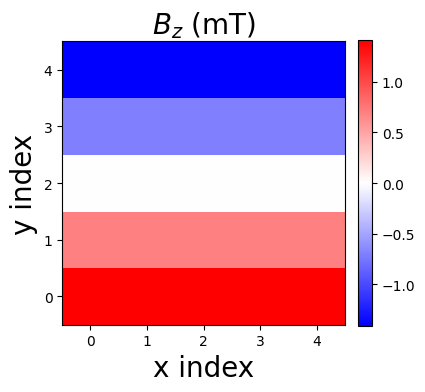

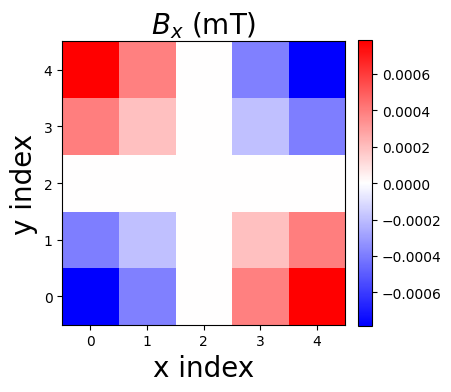

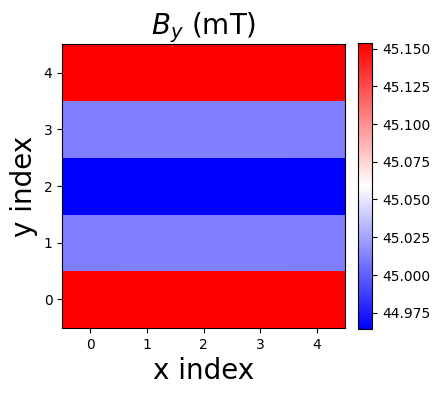

In [ ]:
#Magnetic profile plotting
print(f'length = {bar_magnet.Length*1e3:.2f} mm')
print(f'width = {bar_magnet.Width*1e3:.2f} mm')
print(f'thickness = {bar_magnet.Thickness*1e3} mm')
print(f'distance = {bar_magnet.Distance*1e3} mm')
plt.figure(figsize=(4,4))
im1 = plt.imshow(matrix_B_z.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_z$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im2 = plt.imshow(matrix_B_x.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_x$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im3 = plt.imshow(matrix_B_y.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im3,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_y$ (mT)',size = 20)
plt.show()


#ODMR spectra
x = np.linspace(1e9,6e9,150)   #2.8e9 to 2.85e9
# fig = plt.figure(figsize=(27, 25))
# k = 1
# print(f'ODMR spectra at z = {z_mm}mm with y angle {yangle*180/np.pi} degrees and x angle {xangle*180/np.pi} degrees. (horizontal x axis and vertical y axis)')                        # subplot index
# for j in range(4, -1, -1):
#     for i in range(5):
#         peaks = ODMR_sim(matrix_B_x[i,j], matrix_B_y[i,j], matrix_B_z[i,j])
#         y_values = y(x,peaks)
#         plt.subplot(5,5,k)
#         plt.title(f"matrix point ({i+1},{j+1})",size = 8)
#         plt.xlabel("Microwave frequency(Hz)",size = 8)
#         plt.ylabel("ODMR contrast", size = 8)
#         plt.plot(x,y_values)
#         #plt.legend(fontsize=5)
#         k = k + 1

# plt.show()





# fig = plt.figure(figsize=(17, 16))
# k = 1
# print(f'ODMR spectra at z = {z_mm}mm with y angle {yangle*180/np.pi} degrees and x angle {xangle*180/np.pi} degrees. (horizontal x axis and vertical y axis)')                        # subplot index
# for j in range(4, -1, -1):
#   for i in range(5):
#     if i%2==0 and j%2==0:
#       peaks = ODMR_sim(matrix_B_x[i,j], matrix_B_y[i,j], matrix_B_z[i,j])
#       y_values = y(x,peaks)
#       ax = fig.add_subplot(3,3,k)
#       if i == 0:
#         ax.tick_params(axis="y", direction="in", length = 5, width = 2)
#       else:
#         ax.tick_params(axis="y", direction="inout", length = 10, width = 2)
#       ax.set_xticks(ticks = np.arange(x[0], x[-1], 0.002e9)/1e9, minor = True)
#       ax.set_xticks(ticks = np.arange(2.81e9, 2.841e9, 0.02e9)/1e9)
#       ax.set_yticklabels('')
#       if j != 0:
#         ax.set_xticklabels('')
#       ax.tick_params(axis="x", direction="in", length = 6, labelsize = 28, width = 2)
#       ax.tick_params(axis="x", which = "minor", direction="in", length = 3, width = 2)
#       plt.plot(x/1e9,y_values*1e5)
#       plt.margins(x=0)
#       k = k + 1
# plt.subplots_adjust(wspace=0, hspace=0)
# fig.text(0.5, 0.04, 'Microwave frequency (GHz)', ha='center',fontsize = 45)
# plt.show()

Magnet 2

thickness = 6.35 mm
distance = 60.0 mm


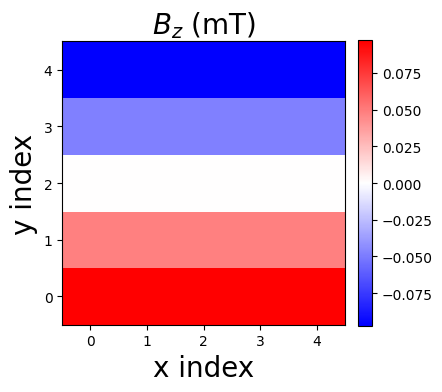

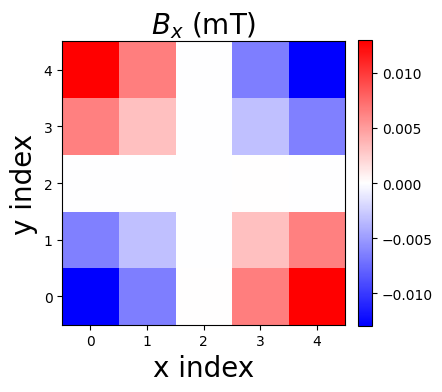

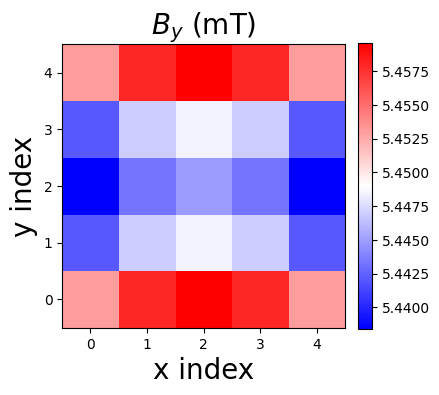

In [ ]:
bar_magnet.Thickness = 6.35e-3
bar_magnet.Distance = 60e-3
matrix_B_x, matrix_B_y, matrix_B_z = magnetic_profile(bar_magnet, z_mm, yangle = yangle, xangle = xangle)
print(f'thickness = {bar_magnet.Thickness*1e3} mm')
print(f'distance = {bar_magnet.Distance*1e3} mm')
plt.figure(figsize=(4,4))
im1 = plt.imshow(matrix_B_z.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_z$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im2 = plt.imshow(matrix_B_x.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_x$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im3 = plt.imshow(matrix_B_y.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im3,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_y$ (mT)',size = 20)
plt.show()

Magnet 3

thickness = 3.17 mm
distance = 20.0 mm


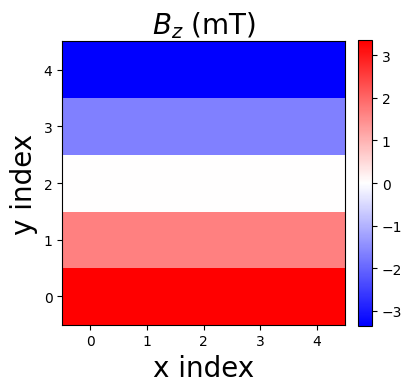

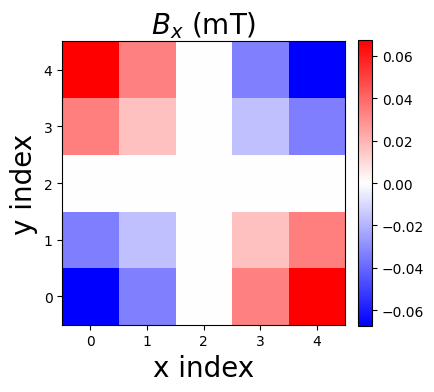

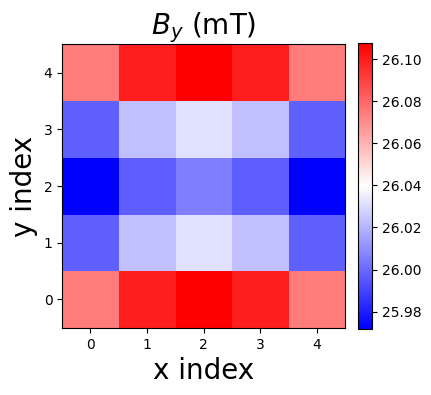

In [ ]:
bar_magnet.Thickness = 3.17*1e-3
bar_magnet.Distance = 20*1e-3
matrix_B_x, matrix_B_y, matrix_B_z = magnetic_profile(bar_magnet, z_mm, yangle = yangle, xangle = xangle)
print(f'thickness = {bar_magnet.Thickness*1e3} mm')
print(f'distance = {bar_magnet.Distance*1e3} mm')
plt.figure(figsize=(4,4))
im1 = plt.imshow(matrix_B_z.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_z$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im2 = plt.imshow(matrix_B_x.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_x$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im3 = plt.imshow(matrix_B_y.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im3,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_y$ (mT)',size = 20)
plt.show()

Magnet 1

In [ ]:
bar_magnet.Thickness = 12.7*1e-3
bar_magnet.Length = 25.4 * 3e-3
print(f'magnet_1 with thickness {bar_magnet.Thickness*1e3} mm')
print(f'{'z_mm':>6}   |  {'1mm dBx, dBy (uT)':>20}  |  {'1mm Bx, By (mT)':>20}  | {'0.5mm dBx, dBy (uT)':>20} | {'0.5mm Bx, By (mT)':>20}  |')
d1 = np.array([20,80])
z = np.array([1,0.5])
for d in d1:
  bar_magnet.Distance = mm2m(d)
  dBx = np.zeros(2)
  Bx = np.zeros(2)
  dBy = np.zeros(2)
  By = np.zeros(2)
  for i in range(2):
    matrix_B_x, matrix_B_y, _ = magnetic_profile(bar_magnet, z[i], yangle = yangle, xangle = xangle)
    dBx[i] = matrix_B_x.max() - matrix_B_x.min()
    Bx[i] = (matrix_B_x.max() + matrix_B_x.min())/2
    dBy[i] = matrix_B_y.max() - matrix_B_y.min()
    By[i] = (matrix_B_y.max() + matrix_B_y.min())/2
  print(f'd={d}mm   |{dBx[0]*1e6:10.1f},{dBy[0]*1e6:10.1f}   |{Bx[0]*1e3:10.1f},{By[0]*1e3:10.1f}   |{dBx[1]*1e6:10.1f},{dBy[1]*1e6:10.1f} |{Bx[1]*1e3:10.1f},{By[1]*1e3:10.1f}  ')

magnet_1 with thickness 12.7 mm
  z_mm   |     1mm dBx, dBy (uT)  |       1mm Bx, By (mT)  |  0.5mm dBx, dBy (uT) |    0.5mm Bx, By (mT)  |
d=20mm   |       5.8,     796.8   |       0.0,      84.0   |       5.8,     835.9 |      -0.0,      85.0  
d=80mm   |       6.5,      10.9   |       0.0,       8.9   |       6.6,      10.9 |       0.0,       8.9  


Magnet 2

In [ ]:
bar_magnet.Thickness = 6.35*1e-3
print(f'magnet_2 with thickness {bar_magnet.Thickness*1e3} mm')
print(f'{'z_mm':>6}   |  {'1mm dBx, dBy (uT)':>20}  |  {'1mm Bx, By (mT)':>20}  | {'0.5mm dBx, dBy (uT)':>20} | {'0.5mm Bx, By (mT)':>20}  |')
d1 = np.array([20,60])
z = np.array([1,0.5])
for d in d1:
  bar_magnet.Distance = mm2m(d)
  dBx = np.zeros(2)
  Bx = np.zeros(2)
  dBy = np.zeros(2)
  By = np.zeros(2)
  for i in range(2):
    matrix_B_x, matrix_B_y, _ = magnetic_profile(bar_magnet, z[i], yangle = yangle, xangle = xangle)
    dBx[i] = matrix_B_x.max() - matrix_B_x.min()
    Bx[i] = (matrix_B_x.max() + matrix_B_x.min())/2
    dBy[i] = matrix_B_y.max() - matrix_B_y.min()
    By[i] = (matrix_B_y.max() + matrix_B_y.min())/2
  print(f'd={d}mm   |{dBx[0]*1e6:10.1f},{dBy[0]*1e6:10.1f}   |{Bx[0]*1e3:10.1f},{By[0]*1e3:10.1f}   |{dBx[1]*1e6:10.1f},{dBy[1]*1e6:10.1f} |{Bx[1]*1e3:10.1f},{By[1]*1e3:10.1f}  ')

magnet_2 with thickness 6.35 mm
  z_mm   |     1mm dBx, dBy (uT)  |       1mm Bx, By (mT)  |  0.5mm dBx, dBy (uT) |    0.5mm Bx, By (mT)  |
d=20mm   |     308.3,     779.0   |       0.0,      57.9   |     311.2,     813.8 |      -0.0,      58.7  
d=60mm   |      27.2,      23.3   |       0.0,       5.7   |      27.2,      23.4 |      -0.0,       5.7  


Magnet 3

In [ ]:
bar_magnet.Thickness = 3.17*1e-3
print(f'magnet_3 with thickness {bar_magnet.Thickness*1e3} mm')
print(f'{'z_mm':>6}   |  {'1mm dBx, dBy (uT)':>20}  |  {'1mm Bx, By (mT)':>20}  | {'0.5mm dBx, dBy (uT)':>20} | {'0.5mm Bx, By (mT)':>20}  |')
d1 = np.array([20,50])
z = np.array([1,0.5])
for d in d1:
  bar_magnet.Distance = mm2m(d)
  dBx = np.zeros(2)
  Bx = np.zeros(2)
  dBy = np.zeros(2)
  By = np.zeros(2)
  for i in range(2):
    matrix_B_x, matrix_B_y, _ = magnetic_profile(bar_magnet, z[i], yangle = yangle, xangle = xangle)
    dBx[i] = matrix_B_x.max() - matrix_B_x.min()
    Bx[i] = (matrix_B_x.max() + matrix_B_x.min())/2
    dBy[i] = matrix_B_y.max() - matrix_B_y.min()
    By[i] = (matrix_B_y.max() + matrix_B_y.min())/2
  print(f'd={d}mm   |{dBx[0]*1e6:10.1f},{dBy[0]*1e6:10.1f}   |{Bx[0]*1e3:10.1f},{By[0]*1e3:10.1f}   |{dBx[1]*1e6:10.1f},{dBy[1]*1e6:10.1f} |{Bx[1]*1e3:10.1f},{By[1]*1e3:10.1f}  ')

magnet_3 with thickness 3.17 mm
  z_mm   |     1mm dBx, dBy (uT)  |       1mm Bx, By (mT)  |  0.5mm dBx, dBy (uT) |    0.5mm Bx, By (mT)  |
d=20mm   |     169.0,     531.5   |      -0.0,      36.1   |     170.8,     558.7 |      -0.0,      36.7  
d=50mm   |      30.6,      28.4   |       0.0,       5.1   |      30.7,      28.6 |       0.0,       5.1  


In [ ]:
fig = plt.figure(figsize=(27, 25))
k= 1
for j in range(4, -1, -1):
    for i in range(5):
        peaks = ODMR_sim(matrix_B_x[i,j], matrix_B_y[i,j], matrix_B_z[i,j])
        #print(peaks[0])
        #y_values = y(x,peaks)
        plt.subplot(5,5,k)
        #plt.title(f"matrix point ({i+1},{j+1})",size = 8)
        #plt.xlabel("Microwave frequency(Hz)",size = 8)
        #plt.ylabel("ODMR contrast", size = 8)
        plt.plot(peaks[0], np.zeros(8), 'o', markersize = 2)
        #plt.legend(fontsize=5)
        k = k + 1

plt.show()

B grid on the edge

In [ ]:
position_el = np.linspace(-0.8,0.8,5)
matrix_B_x = np.zeros((5,5),float)
matrix_B_y = np.zeros((5,5),float)
matrix_B_z = np.zeros((5,5),float)
bar_magnet.Distance = mm2m(30)
for i in range(5):
  for j in range(5):
    x = position_el[i] + bar_magnet.Length/2e-3
    y = position_el[j]
    matrix_B_x[i,j], matrix_B_y[i,j], matrix_B_z[i,j] = magnetic_profile_point(bar_magnet, x, y, z_mm)


length = 76.20 mm
width = 6.34 mm
thickness = 12.7 mm
distance = 30.0 mm


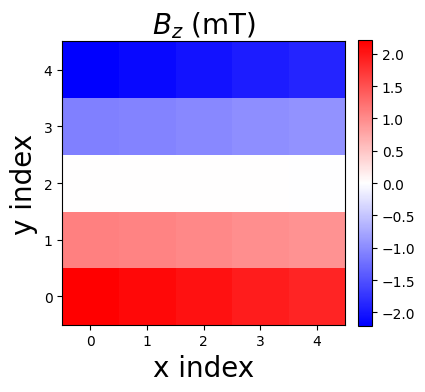

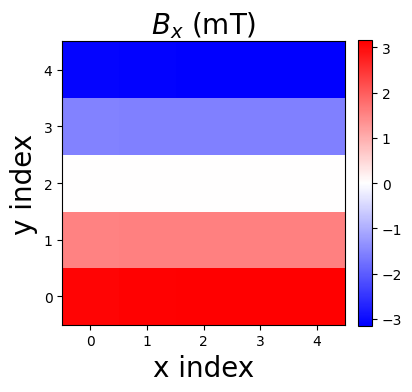

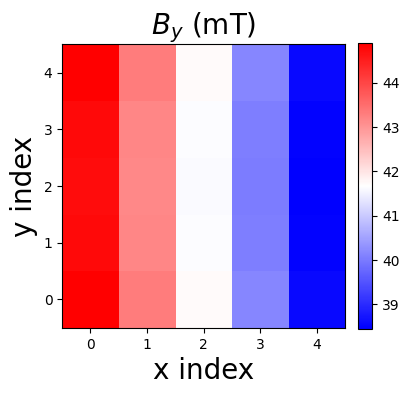

In [ ]:
#Magnetic profile plotting
print(f'length = {bar_magnet.Length*1e3:.2f} mm')
print(f'width = {bar_magnet.Width*1e3:.2f} mm')
print(f'thickness = {bar_magnet.Thickness*1e3} mm')
print(f'distance = {bar_magnet.Distance*1e3} mm')
plt.figure(figsize=(4,4))
im1 = plt.imshow(matrix_B_z.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_z$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im2 = plt.imshow(matrix_B_x.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_x$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im3 = plt.imshow(matrix_B_y.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im3,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('y index',size = 20)
plt.title(f'$B_y$ (mT)',size = 20)
plt.show()